In [6]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') 

path = 'C:/Windows/Fonts/malgun.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
pd.set_option('display.max_columns', None)

# 4. 시계열 (전처리, 탐색적 분석, 모델링)

## [연습문제]

### 1. 다음은 Microsoft의 주식 가격 데이터이다. 데이터는 날짜와 주식 종가로 구성되어 있다. 다음 데이터를 주 단위 평균 가격으로 다운샘플링하고, 앞의 데이터 300개를 down_head, 뒤의 데이터 14개를 down_tail로 분할하시오. (데이터 링크는 아래 코드 참조)

In [7]:
'''
데이터를 다운받아서 Date컬럼을 시계열로 변경 후, 인덱스로 지정합니다.
'''
import pandas as pd
ms = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv', encoding='euc-kr')
ms['Date'] = pd.to_datetime(ms['Date'])
ms = ms.set_index('Date')

In [8]:
'''
인덱스가 시계열로 된 데이터가 시계열 데이터 입니다. .resample로 'W'.mean() 하면 주단위 평균으로 데이터가 변경됩니다.
'''
ms_wm = ms.resample('W').mean()
down_head = ms_wm.head(300)
down_tail =ms_wm.tail(14)

### 2. down_head 데이터로 탐색적 분석을 진행하시오.

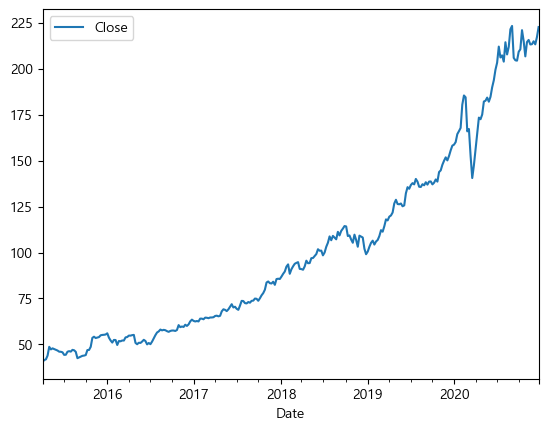

In [9]:
'''
plot을 그려보면 시계열 종가 데이터입니다.
'''

down_head.plot();

시계열데이터로 나타냄

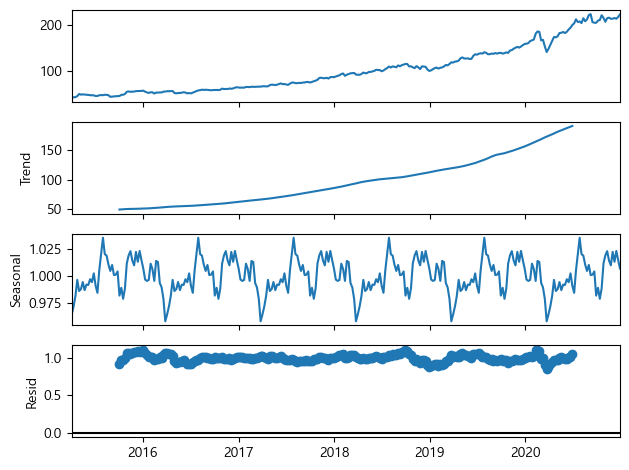

In [10]:
'''
seasonal_decompose을 통해 시계열 데이터를 트랜드, 시즌, 잔차로 구분/확인 가능합니다.
'''
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(down_head, model= 'multiplicative')
result.plot()
plt.show()

시계열분해 
- Trend : 장기 추세
- seasonal : 계절성
- resid : 시계열의 잔차

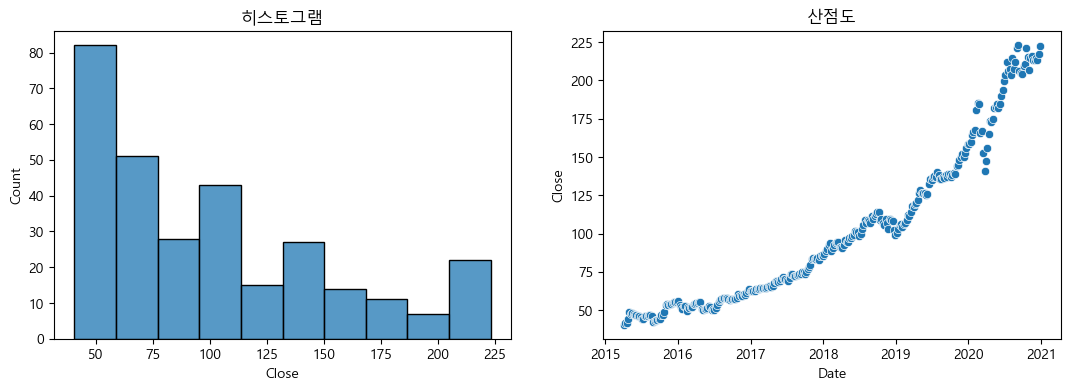


 [요약통계량]
       count    mean    std   min    25%    50%     75%    max
Close  300.0  101.73  51.32  40.5  57.51  90.93  136.58  223.2


In [12]:
'''
히스토그램 및 산점도로 데이터를 확인합니다.
'''

# 일반적 EDA
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(13,4))
ax = sns.histplot(x='Close', data=down_head, ax=axes[0])
ax.set_title('히스토그램')
ax1 = sns.scatterplot(x='Date', y='Close', data=down_head, ax=axes[1])
ax1.set_title('산점도')
plt.show()

# 요약 통계량
print("\n [요약통계량]")
print(down_head.describe().round(2).T)

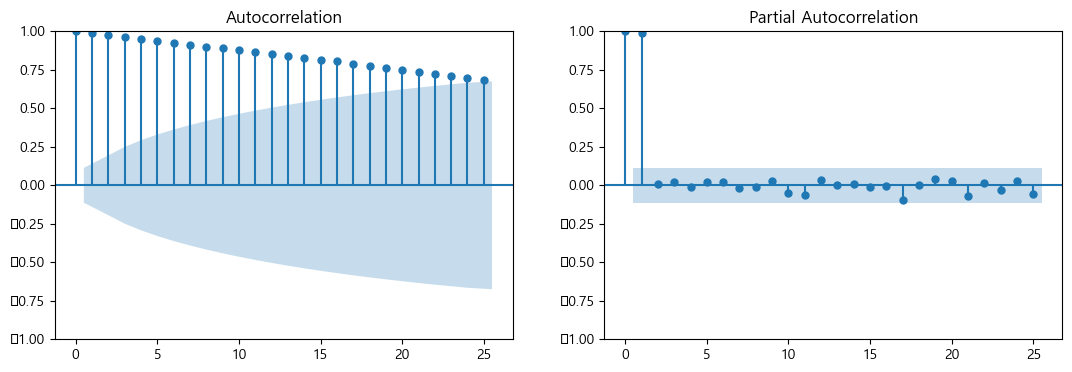

In [14]:
'''
시계열데이터를 acf와 pacf로 분해하여 확인하는 것입니다. 상관도가 0이 되는 점을 각각 찾습니다.
'''

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(13,4))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()

### 3. down_head 데이터로 시계열 모델을 적합하시오.

ADF, KPSS 검정을 통해 시계열이 비정상임을 알 수 있다.

In [17]:
'''
adfuller,kpss검정을 진행하여 p-value를 확인하여 시계열데이터의 정상성을 확인합니다.
'''

from statsmodels.tsa.stattools import adfuller, kpss
adf  = adfuller(down_head, regression= 'ct')
print("ADF Statistics: {:.3f}, p-value: {:.3f}".format(adf[0], adf[1]))

kps = kpss(down_head, regression='c', nlags='auto')
print("KPSS Statistics: {:.3f}, p-value: {:.3f}".format(kps[0], kps[1]))

ADF Statistics: -0.813, p-value: 0.965
KPSS Statistics: 2.593, p-value: 0.010


- ADF(Augmented Dickey-Fuller) 귀무가설(단위근이 존재한다)을 기각할 수 없습니다
    - 즉, 이 시계열은 비정상 시계열
- KPSS(Kwiatkowski-Phillips-Schmidt-Shin) 귀무가설(정상 시계열이다)을 기각
    - 즉, 이 시계열은 비정상 시계열

- 차분 후 (ts.diff(n)) 정상성 여부를 확인한다. ADF의 가설은
    - H0 : 데이터가 정상성을 갖지 않는다. (단위근이 존재한다)
    - H1 : 데이터가 정상성을 갖는다

In [18]:
'''
차분을 한 후 정상성을 확인하니 정상이 나왔습니다.
'''

diff_1 = down_head.diff(1)
diff_1 = diff_1.dropna()
adf  = adfuller(diff_1, regression= 'ct')
print('adf : ',adf[0])
print('p-value : ',adf[1])

adf :  -10.724158085478326
p-value :  7.603939559033034e-17


- 1로 차분 결과 정상성 가짐

In [27]:
'''
pip install pmdarima
오토아리마를 통해 p, q를 자동으로 찾을 수 있습니다.
즉 acf, pacf 그래프에서 수동으로 찾을 필요가 없습니다.
'''

# 위에서 구한 차분 1 대입, 계절성은 12개월이므로 12 대입하여 적합
from pmdarima import auto_arima
auto_model = auto_arima(down_head, d=1, seasonal=True, m=12, # 중요한 차분, 계절성 부터 수동으로 셋탕
                        # information_criterion='aic', trace=True,
                        # start_p=0, start_q=0, max_p=3, max_q=3,
                        # start_P=0 ,start_Q=0, max_P=3, max_Q=3,
                        )

### 4. 해당 모델로 down_tail의 기간의 값을 예측하고, 적절한 평가 지표를 선택하여 해당 모델을 평가 하시오.

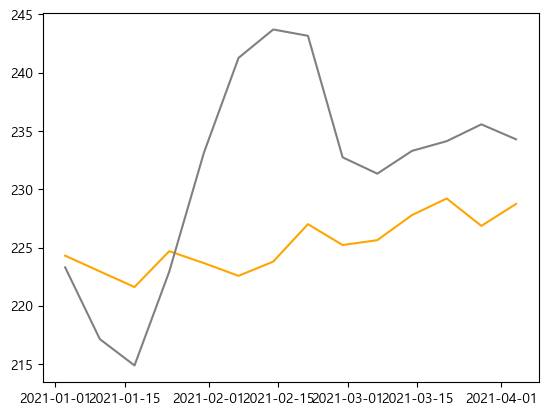

In [28]:
'''
오랜지색이 예측선입니다.
'''
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(down_tail),X=down_tail.index))
plt.plot(auto_pred_y, color = 'orange')
plt.plot(down_tail, color ='grey');

- 급등, 급락은 예측하기 어려웠지만, 전반적 방향성은 바르게 예측하는 것 확인할 수 있다.

In [29]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(5, 1, 5)   Log Likelihood                -761.201
Date:                Sun, 21 Apr 2024   AIC                           1546.401
Time:                        20:33:46   BIC                           1590.807
Sample:                    04-05-2015   HQIC                          1564.175
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9376      0.320      2.929      0.003       0.310       1.565
ar.L1         -0.1095      0.136     -0.805      0.421      -0.376       0.157
ar.L2         -0.2276      0.117     -1.950      0.051      -0.456       0.001
ar.L3         -0.0906      0.117     -0.772      0.440      -0.321       0.139
ar.L4          0.4217      0.108      3.912      0.000       0.210       0.633
ar.L5         -0.5748      0.137     -4.201      0.000      -0.843      -0.307
ma.L1          0.1950      0.168      1.161      0.246      -0.134       0.524
ma.L2          0.2285      0.143      1.598      0.110      -0.052       0.509
ma.L3          0.0509      0.133      0.382      0.702      -0.210       0.312
ma.L4         -0.5360      0.130     -4.113      0.000      -0.791      -0.281
ma.L5          0.3488      0.177      1.975      0.048       0.003       0.695
sigma2         9.4097      0.449     20.958      0.000       8.530      10.290
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               885.45
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              11.18   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> 모델 요약 통계량
> 해당모델은 p=5, d=1, q=5로 정상화하여 예측해준 ARIMA모델

- 관측치 수: 300개
- 로그 가능성: 680.981
- AIC: 1546.401
- BIC: 1590.807
- HQIC: 1564.175

- 계수 추정치 확인
    - ar.L4, ar.L5, ma.L4, 분산(sigma2) 계수 통계적으로 유의

- 모델 적합도 검정


Ljung-Box 통계량: 0.03 (p-value=0.86) - 잔차의 자기상관 없음
Jarque-Bera 통계량: 155.25 (p-value=0.00) - 잔차 정규성 가정 위배
이분산성 검정 통계량: 1.25 (p-value=0.00) - 이분산성 없음


- 잔차 분포 특성


    - 왜도(Skew): -0.92
    - 첨도(Kurtosis): 11.23
```
이 모델은 AR(1)과 MA(2) 성분을 가지며, 대부분의 계수가 유의한 것으로 나타납니다. Ljung-Box 통계량과 이분산성 검정 결과를 보면 잔차의 자기상관과 이분산성 문제는 없는 것으로 보입니다.


하지만 Jarque-Bera 통계량 결과에서 잔차의 정규성 가정을 위배하는 것으로 나타납니다. 잔차의 왜도와 첨도 값도 정규분포와 다소 차이가 있습니다.


따라서 이 모델은 시계열 데이터를 어느 정도 설명할 수 있지만, 잔차의 정규성 가정 위배로 인해 모델 적합도에 한계가 있을 수 있습니다. 잔차 분포 변환이나 다른 모델 탐색을 고려해볼 필요가 있습니다.
```

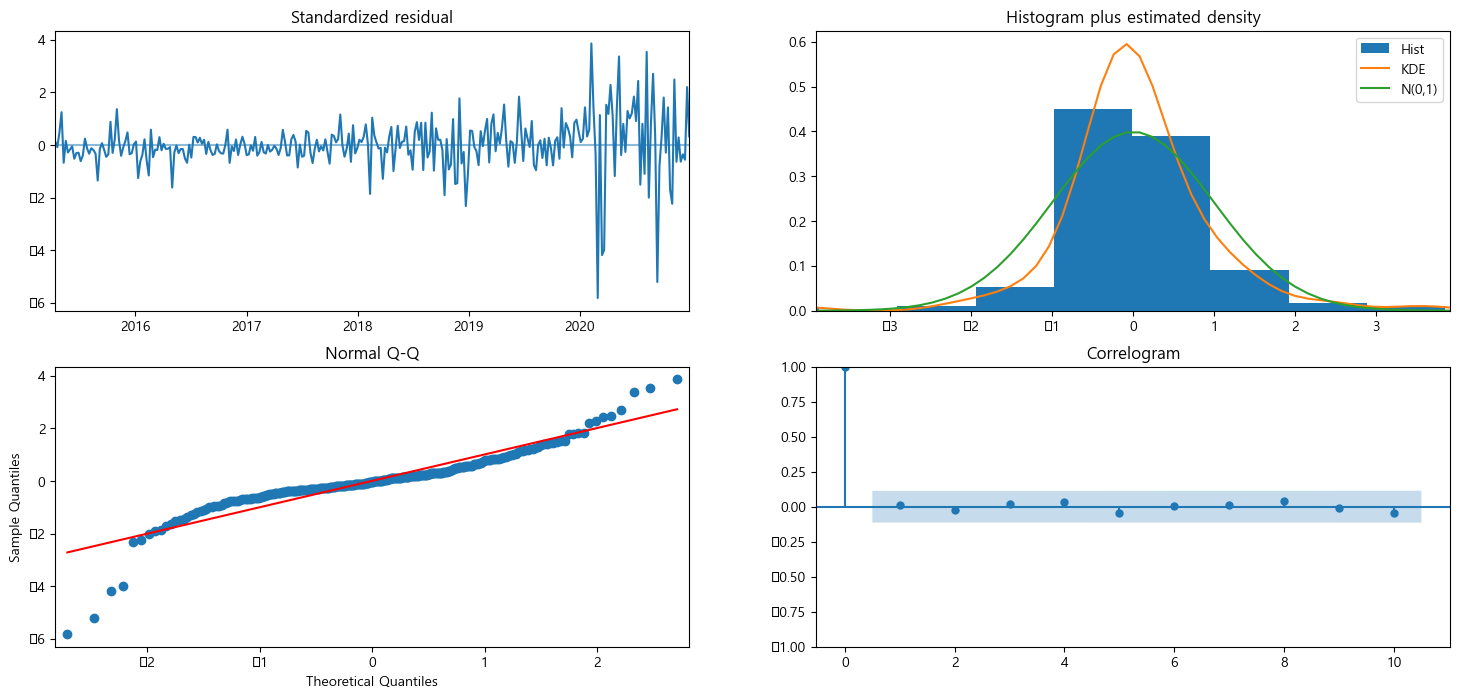

In [30]:
'''
모델을 plot_diagnostics를 해보면 정규분포와 비교하는 히스토그램및 kde, 표준편차, qqplot, acf를 확인할 수 있습니다.
'''

auto_model.plot_diagnostics(figsize=(18, 8))
plt.show()

## [기출문제]

# 1. 가구별 전력 사용량 시계열 문제
- ADP 실기 20회 문제 (https://www.datamanim.com/dataset/ADPpb/00/20.html)

In [26]:
import pandas as pd
ele= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/20/problem2.csv')
ele.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401760 entries, 0 to 401759
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   houseCode          401760 non-null  object 
 1   date               401760 non-null  object 
 2   power consumption  401760 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.2+ MB


### 1-1. 각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라. 군집화를 위한 데이터 구성의 이유를 설명하라. (군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)
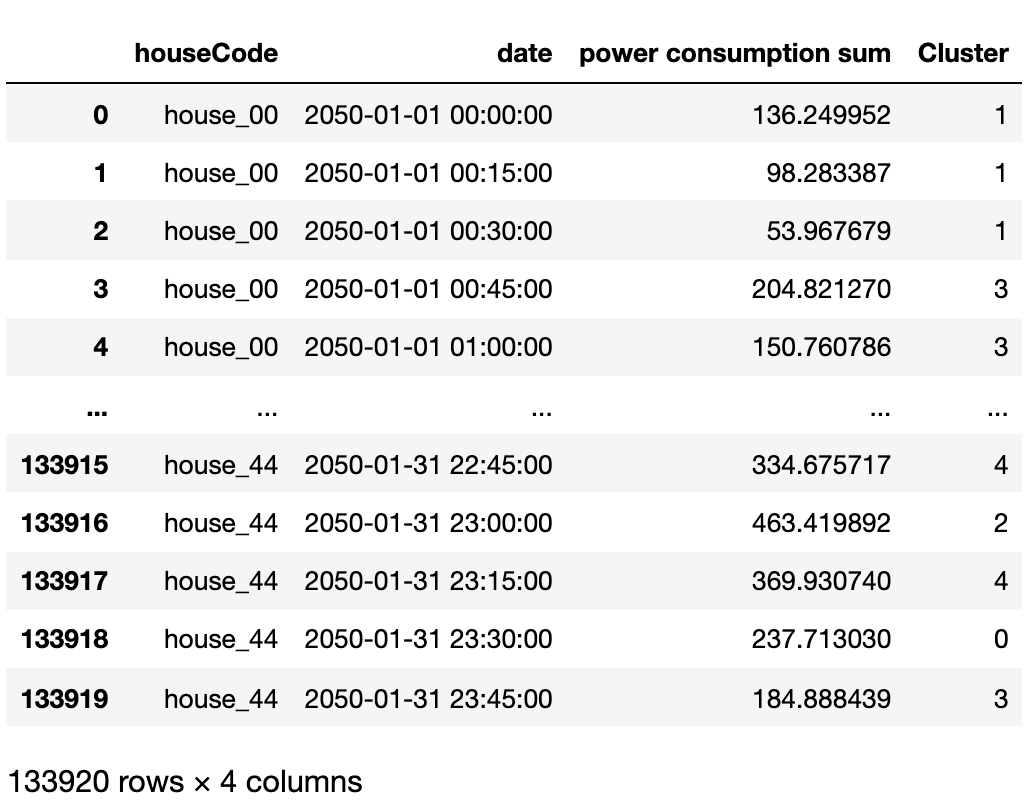

In [42]:
ele= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/20/problem2.csv')
ele['date'] = pd.to_datetime(ele['date']) # datetime으로 변환
ele_ = ele.set_index('date')
ele_.groupby('houseCode').resample('15min').sum()

houseCode  power consumption
houseCode date                                                            
house_00  2050-01-01 00:00:00  house_00house_00house_00         136.249952
          2050-01-01 00:15:00  house_00house_00house_00          98.283387
          2050-01-01 00:30:00  house_00house_00house_00          53.967679
          2050-01-01 00:45:00  house_00house_00house_00         204.821270
          2050-01-01 01:00:00  house_00house_00house_00         150.760786
...                                                 ...                ...
house_44  2050-01-31 22:45:00  house_44house_44house_44         334.675717
          2050-01-31 23:00:00  house_44house_44house_44         463.419892
          2050-01-31 23:15:00  house_44house_44house_44         369.930740
          2050-01-31 23:30:00  house_44house_44house_44         237.713030
          2050-01-31 23:45:00  house_44house_44house_44         184.888439

[133920 rows x 2 columns]

In [46]:
ele_

date                 houseCode
2050-01-01 00:00:00  house_00     136.249952
                     house_01     360.345253
                     house_02     466.881645
                     house_03     155.519631
                     house_04      48.895911
                                     ...    
2050-01-31 23:45:00  house_40     324.414055
                     house_41     306.345603
                     house_42     144.731444
                     house_43     132.019101
                     house_44     184.888439
Name: power consumption, Length: 133920, dtype: float64

In [47]:
import pandas as pd
ele= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/20/problem2.csv')
ele['date'] = pd.to_datetime(ele['date']) # datetime으로 변환
ele_ = ele.set_index('date').groupby([pd.Grouper(freq='15Min'), 'houseCode']).agg({'power consumption':'sum'})#15분단위

ele = ele_.reset_index()  #15분단위 변환 후 일반df화
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0) #k-means
kmeans.fit(ele[['power consumption']])
ele['Cluster'] = kmeans.labels_
ele

,date,houseCode,power consumption,Cluster
0,2050-01-01 00:00:00,house_00,136.249952,1
1,2050-01-01 00:00:00,house_01,360.345253,3
2,2050-01-01 00:00:00,house_02,466.881645,2
3,2050-01-01 00:00:00,house_03,155.519631,4
4,2050-01-01 00:00:00,house_04,48.895911,1
...,...,...,...,...
133915,2050-01-31 23:45:00,house_40,324.414055,3
133916,2050-01-31 23:45:00,house_41,306.345603,0
133917,2050-01-31 23:45:00,house_42,144.731444,1
133918,2050-01-31 23:45:00,house_43,132.019101,1


- 매 15분간의 전기소비량을 기준으로 0~4의 군집 라벨을 구성하였다.
- 집단 별 소비량의 평균, 표준편차 등 통계량을 확인하여 적정 누진 전기세율을 구성할 수 있다

In [49]:
ele.groupby('Cluster').agg({'power consumption':['count','mean','std','min','max']})

power consumption                                               
                    count        mean        std         min         max
Cluster                                                                 
0                   36489  263.628048  23.470717  224.813013  307.146003
1                   25859  105.052529  29.436233    6.003680  145.451382
2                    8476  469.575219  53.814280  410.381326  900.492823
3                   24015  350.506917  28.809399  307.149883  410.360982
4                   39081  186.315964  22.704657  145.464370  224.804662

### 1-2. 위의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라 (수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)
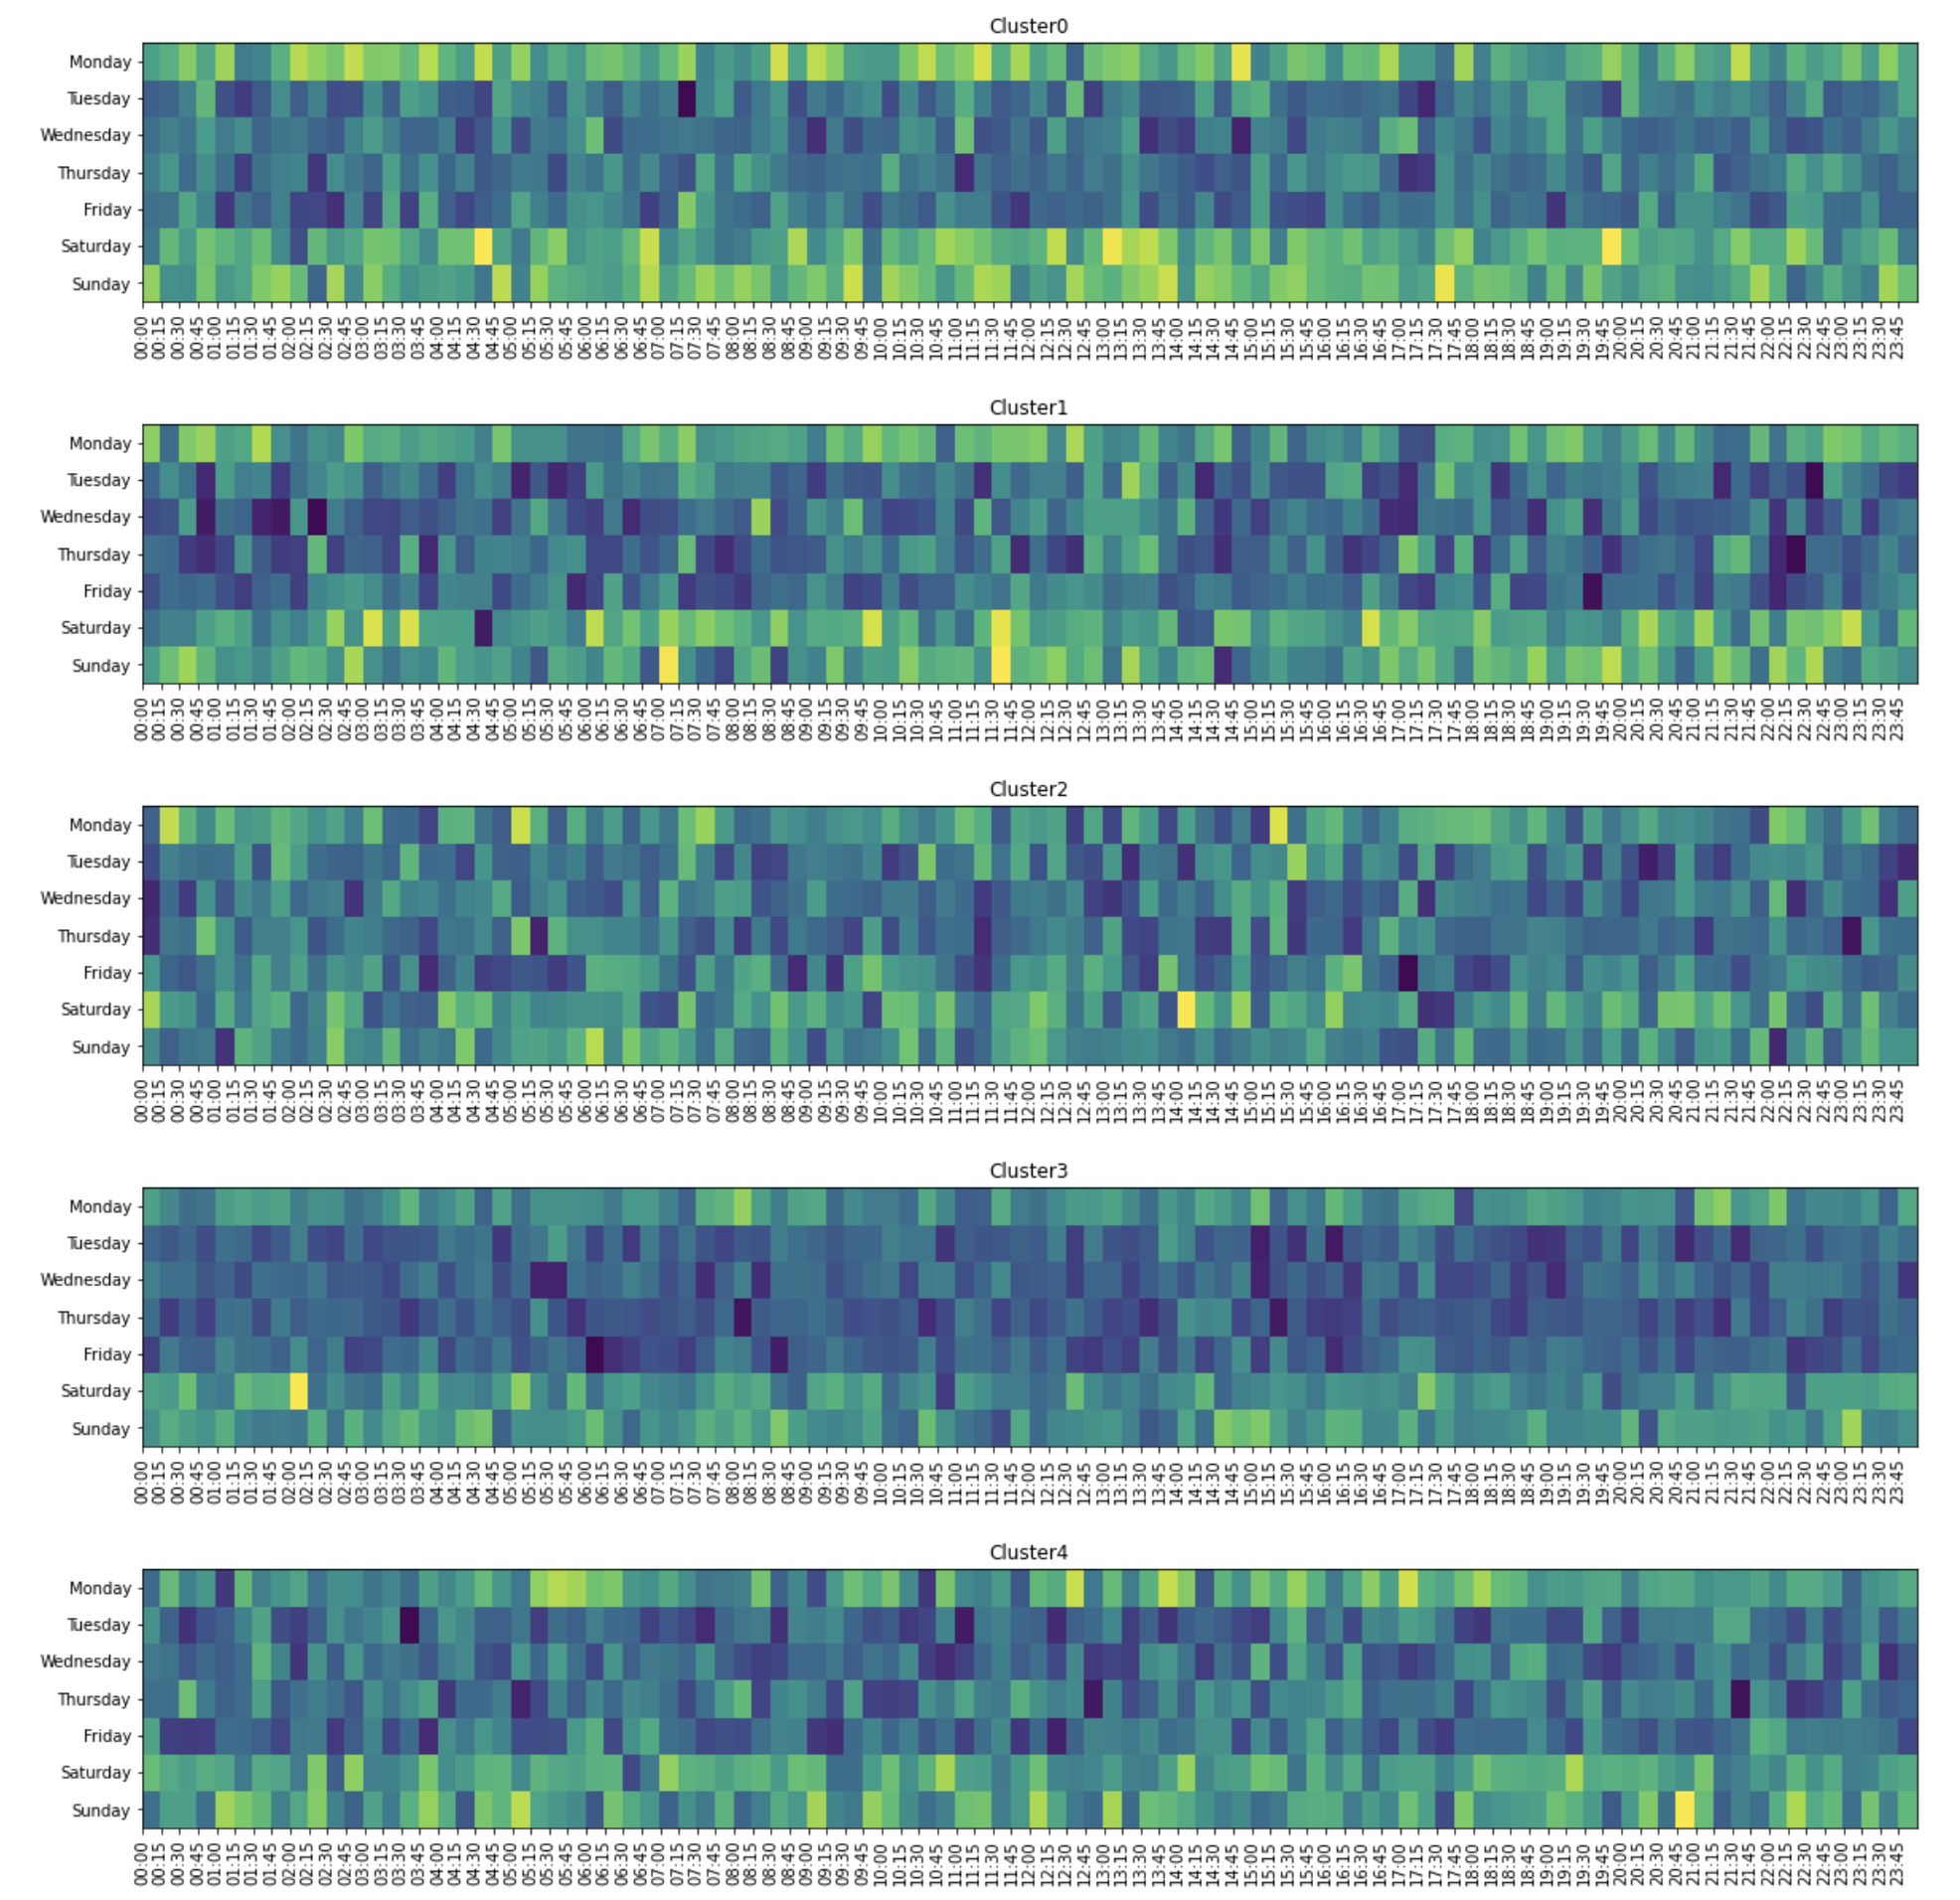

In [50]:
week_l = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
week_d = {i:d for i,d in enumerate(week_l)}
ele['weekday'] = ele['date'].dt.weekday # 요일추가
ele['time'] = ele['date'].dt.time.apply(lambda t: t.strftime('%H:%M')) # 시간추가 

In [27]:
# import matplotlib.pyplot as plt
# plt.colormaps()

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# 피벗 테이블 생성
pivot_table = ele.pivot_table(index=['time','weekday'], columns='Cluster', values='power consumption', aggfunc='sum')

# 그리드 생성
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))

# Cluster별로 반복
for i, cluster in enumerate(ele['Cluster'].unique()):
    # Cluster별 데이터 추출
    cluster_data = pivot_table[cluster].unstack(level=0) # 멀티인덱스에서 시간[0번째]을 컬럼으로 보냄
    
    # 히트맵 그리기
    sns.heatmap(cluster_data, ax=axes[i], cmap='YlGnBu_r', annot=False, cbar=False)
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontdict={'rotation':0})
    

# 전체 제목 설정
fig.suptitle('Power Consumption by Weekday and Time', fontsize=16, y=1.05)

# 축 레이블 설정
fig.supxlabel('Time', fontsize=12)
fig.supylabel('Weekday', fontsize=12)

# 여백 조정
plt.subplots_adjust(wspace=0.1,hspace=1) 

# 컬러바 추가
fig.colorbar(axes[-1].collections[0], ax=axes.ravel().tolist(), location='top', shrink=0.5)

# 2. 나라별 코로나19 확진자 시계열 문제
- ADP 실기 17회 문제 (https://www.datamanim.com/dataset/ADPpb/00/17.html)
[데이터 설명]  
> - date : 일자
> - total_cases : 누적 확인자
> - total_deaths : 누적 사망자
> - new_tests : 검사자
> - population : 인구
> - new_vaccinations : 백신 접종자

In [1]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/17/problem2.csv')
df

,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations
0,Afghanistan,2020-02-24,5.0,NaN,NaN,39835428.0,NaN
1,Afghanistan,2020-02-25,5.0,NaN,NaN,39835428.0,NaN
2,Afghanistan,2020-02-26,5.0,NaN,NaN,39835428.0,NaN
3,Afghanistan,2020-02-27,5.0,NaN,NaN,39835428.0,NaN
4,Afghanistan,2020-02-28,5.0,NaN,NaN,39835428.0,NaN
...,...,...,...,...,...,...,...
136926,Zimbabwe,2021-11-26,133836.0,4704.0,2719.0,15092171.0,31285.0
136927,Zimbabwe,2021-11-27,133836.0,4704.0,4152.0,15092171.0,16111.0
136928,Zimbabwe,2021-11-28,133951.0,4705.0,1044.0,15092171.0,8252.0
136929,Zimbabwe,2021-11-29,134226.0,4706.0,3067.0,15092171.0,17809.0


### 2-1. 마지막 일자를 기준으로 인구 대비 확진자 비율이 높은 상위 5개 국가를 구하여라. 상위 5개 국가별로 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자, 그래프, 범례를 이용해서 가독성 있게 만들어라

In [2]:
not_country = ['World', 'High income' ,'Upper middle income', 'Asia', 'Europe','Lower middle income', 'North America', 'European Union', 'South America']

C:\Users\david\AppData\Local\Temp\ipykernel_14172\682764495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:,'case_ratio'] = df_m['total_cases'] / df_m['population'] # 누계확진자비율
C:\Users\david\AppData\Local\Temp\ipykernel_14172\682764495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:,'daily_death'] = df_m.groupby('location')['total_deaths'].diff(1) # 일일사망자
C:\Users\david\AppData\Local\Temp\ipykernel_14172\682764495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

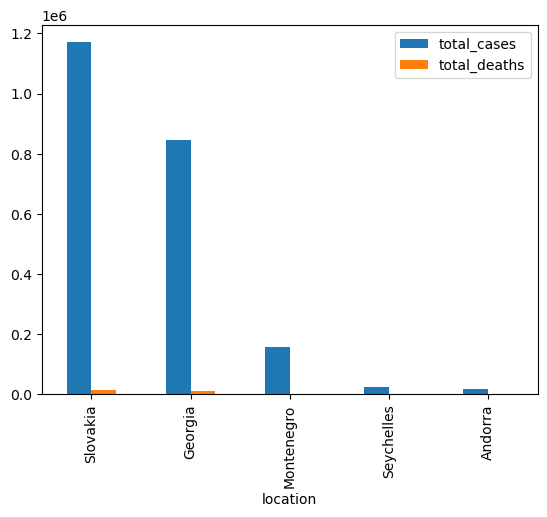

In [3]:
df_m=df[~df['location'].isin(not_country)]
df_m.loc[:,'case_ratio'] = df_m['total_cases'] / df_m['population'] # 누계확진자비율
df_m.loc[:,'daily_death'] = df_m.groupby('location')['total_deaths'].diff(1) # 일일사망자
df_m.loc[:,'daily_cases'] = df_m.groupby('location')['total_cases'].diff(1) # 일일확진자
total_top5 = df_m.drop_duplicates('location',keep='last').sort_values('case_ratio',ascending=False)['location'][:5].values
df_m[df['location'].isin(total_top5)].drop_duplicates('location',keep='last')[['location','total_cases','total_deaths']].sort_values('total_cases',ascending=False).plot(kind='bar', x='location');

누계 확진자 비율의 Top5국가의 누계확진자수, 누계사망자수를 확인

C:\Users\david\AppData\Local\Temp\ipykernel_14172\1853946427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:,'daily_cases_ratio'] = df_m['daily_cases'] / df_m['population'] # 일일확진자비율
C:\Users\david\AppData\Local\Temp\ipykernel_14172\1853946427.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_m[df['location'].isin(daily_top5)].drop_duplicates('location',keep='last')[['location','daily_cases','daily_death']].sort_values('daily_cases',ascending=False).plot(kind='bar', x='location');


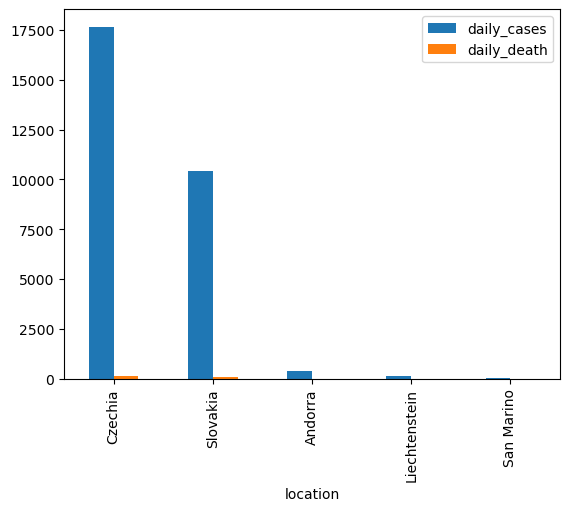

In [4]:
df_m.loc[:,'daily_cases_ratio'] = df_m['daily_cases'] / df_m['population'] # 일일확진자비율
daily_top5 = df_m.drop_duplicates('location',keep='last').sort_values('daily_cases_ratio',ascending=False)['location'][:5].values
df_m[df['location'].isin(daily_top5)].drop_duplicates('location',keep='last')[['location','daily_cases','daily_death']].sort_values('daily_cases',ascending=False).plot(kind='bar', x='location');

일일 확진자 비율의 Top5국가의 일일확진자수, 일일사망자수를 확인
- 체코가 가장 심하며, 슬로바키아도 여전히 확진자수가 많음. 조지아, 몬테그로 등은 진정이 된 것을 확인

In [6]:
!pip install seaborn

C:\Users\david\AppData\Local\Temp\ipykernel_14172\1456435302.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(df_m[df['location'].isin(daily_top5)], x='date',y='daily_cases', hue='location')


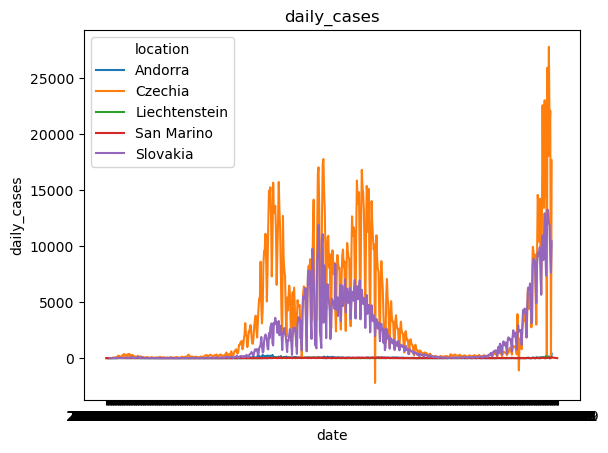

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(df_m[df['location'].isin(daily_top5)], x='date',y='daily_cases', hue='location')
plt.title('daily_cases')
plt.show()

일일확진자 비율 top5국가의 일자별 확진추이 확인

C:\Users\david\AppData\Local\Temp\ipykernel_14172\3573345483.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(df_m[df['location'].isin(daily_top5)], x='date',y='daily_death', hue='location')


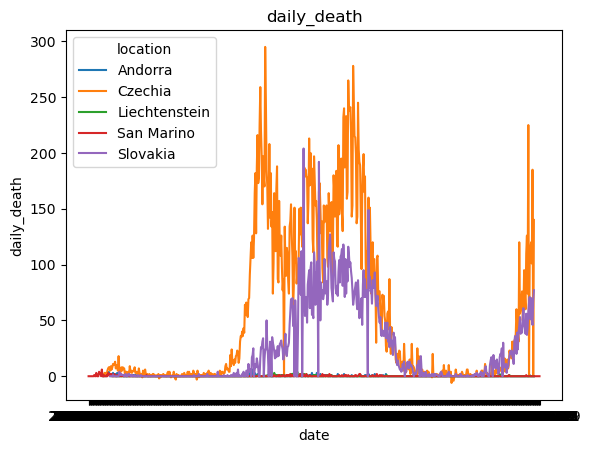

In [15]:
sns.lineplot(df_m[df['location'].isin(daily_top5)], x='date',y='daily_death', hue='location')
plt.title('daily_death')
plt.show()

누계 확진 top5국가의 사망자 비율 추이 확인
- 슬로바키아, 조지아 여전히 심각

### 2-2. 코로나 위험지수를 직접 만들고 그 위험지수에 대한 설명을 적고 위험지수가 높은 국가들 10개를 선정해서 시각화

- 최근 특정기간동안에 빠르게 증가한 국가를 선정하려한다
- daily_cases의 최근 7일간 평균건수, (30일 평균건수를 구한후), ewm을 통한 최근 항목에 높은 가중치를 둔 지수이동윈도를 구한다

In [10]:
df_m['daily_cases_7d']= df_m['daily_cases'].rolling(window=7).mean().ewm(alpha=0.8).mean().bfill()
df_m['daily_cases_30d']= df_m['daily_cases'].rolling(window=30).mean().ewm(alpha=0.8).mean().bfill()
df_m['daily_cases_7d_ratio'] = df_m['daily_cases_7d']/df_m['population']
df_m['daily_cases_30d_ratio'] = df_m['daily_cases_30d']/df_m['population']

C:\Users\david\AppData\Local\Temp\ipykernel_14172\2564621531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m['daily_cases_7d']= df_m['daily_cases'].rolling(window=7).mean().ewm(alpha=0.8).mean().bfill()
C:\Users\david\AppData\Local\Temp\ipykernel_14172\2564621531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m['daily_cases_30d']= df_m['daily_cases'].rolling(window=30).mean().ewm(alpha=0.8).mean().bfill()
C:\Users\david\AppData\Local\Temp\ipykernel_14172\2564621531.py:3: SettingWithCopyWarn

C:\Users\david\AppData\Local\Temp\ipykernel_14172\1176222368.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_m[df['location'].isin(top10)].drop_duplicates('location',keep='last')[['location','daily_cases_7d_ratio','daily_cases_30d_ratio']].sort_values('daily_cases_7d_ratio',ascending=False).plot(kind='bar',x='location');


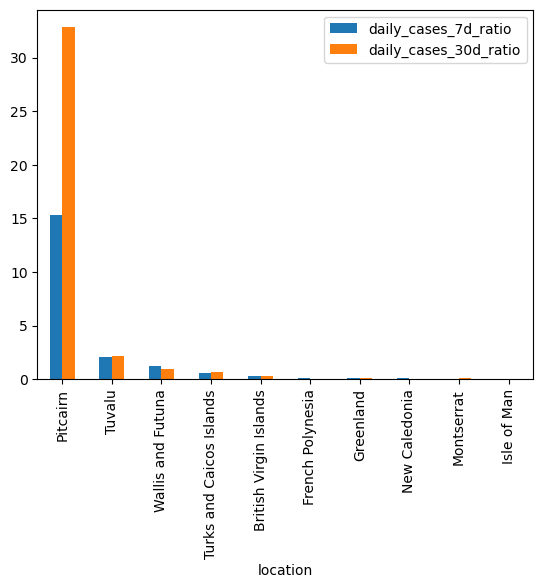

In [11]:
top10 = df_m.drop_duplicates('location',keep='last').sort_values('daily_cases_7d_ratio',ascending=False)['location'][:10].values

df_m[df['location'].isin(top10)].drop_duplicates('location',keep='last')[['location','daily_cases_7d_ratio','daily_cases_30d_ratio']].sort_values('daily_cases_7d_ratio',ascending=False).plot(kind='bar',x='location');

- 최근 7일간 평균확진자 수 비율이 가장 높은 국가 Top10이다. 30일 평균과 비교하여 금주간 늘어나는 추세였는지 확인 가능하다.


### 2-3. 한국의 코로나 신규 확진자 예측해라(선형 시계열모델 + 비선형시계열 각각 한개씩 만들어라) 
> 선형시계열 - arima 비선형 시계열 - randomforest 및 knn을 활용하겠습니다.

In [12]:
df3 = df_m[df_m['location']=='South Korea']
df3['date'] = pd.to_datetime(df3['date'])
df3 = df3.set_index('date')
df3 = df3[['daily_cases']]
df3 = df3.iloc[2:]
df3

C:\Users\david\AppData\Local\Temp\ipykernel_14172\1669154782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['date'] = pd.to_datetime(df3['date'])


,daily_cases
date,
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,1.0
2020-01-27,1.0
...,...
2021-11-26,4067.0
2021-11-27,3928.0
2021-11-28,3304.0


In [13]:
from statsmodels.tsa.stattools import adfuller
adf  = adfuller(df3, regression= 'ct')
print('adf : ',adf[0])
print('p-value : ',adf[1])

adf :  0.6913015547002992
p-value :  0.9970293877473647


In [14]:
diff_1 = df3.diff(1)
diff_1 = diff_1.dropna()
adf  = adfuller(diff_1, regression= 'ct')
print('adf : ',adf[0])
print('p-value : ',adf[1])

adf :  -4.0129638436234965
p-value :  0.008427766729570678


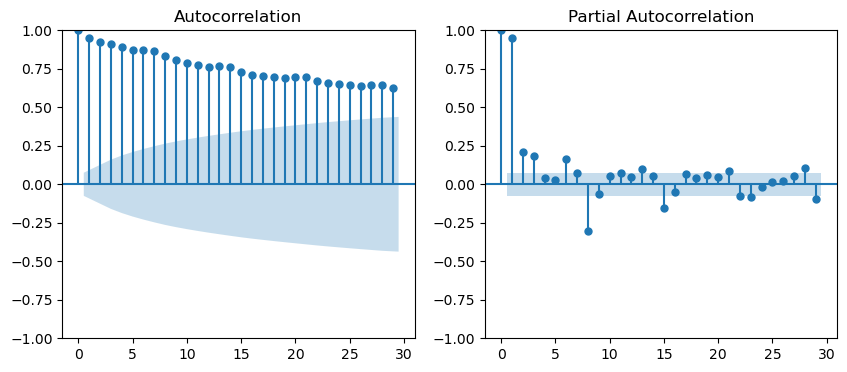

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2,figsize = (10,4))
ax1 = plot_acf(df3['daily_cases'],ax=ax[0])
ax2 = plot_pacf(df3['daily_cases'],ax=ax[1])
plt.show()

In [17]:
training = df3[:-30]
test = df3[-30:]

In [25]:
from pmdarima import auto_arima
auto_model = auto_arima(training, d=1, seasonal=True, m=12, )# 중요한 차분, 계절성 부터 수동으로 셋탕
                        # start_p=0, start_q=0, max_p=3, max_q=3,
                        # start_P=0 ,start_Q=0, max_P=3, max_Q=3,
                        # information_criterion='aic', trace=True)

In [26]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  648
Model:             SARIMAX(2, 1, 4)x(1, 0, [], 12)   Log Likelihood               -3982.440
Date:                             Fri, 17 May 2024   AIC                           7982.880
Time:                                     08:36:39   BIC                           8023.131
Sample:                                 01-23-2020   HQIC                          7998.496
                                      - 10-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0648      2.647     -0.024      0.980      -5.252       5.123
ar.L1          1.2545      0.004    311.081      0.000       1.247       1.262
ar.L2         -0.9998      0.000  -3142.269      0.000      -1.000      -0.999
ma.L1         -1.4711      0.025    -59.855      0.000      -1.519      -1.423
ma.L2          1.0364      0.046     22.777      0.000       0.947       1.126
ma.L3          0.0313      0.053      0.592      0.554      -0.072       0.135
ma.L4         -0.1757      0.034     -5.209      0.000      -0.242      -0.110
ar.S.L12      -0.1218      0.032     -3.819      0.000      -0.184      -0.059
sigma2      1.406e+04    395.456     35.556      0.000    1.33e+04    1.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              6729.09
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               8.56   Skew:                             1.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- KNN 회귀는 가까운 이웃데이터를 사용하여 회귀선을 도출
    - 주어진 입력을 바탕으로 가장 잘 예측된 평균 값의 집합

In [27]:
# 비선형모델에 넣어줄 파생변수 생성
kor3 = df3.copy()
kor3 = kor3.reset_index()
kor3['year'] = kor3['date'].dt.year
kor3['month'] = kor3['date'].dt.month
kor3['day'] = kor3['date'].dt.day
kor3['weekday'] = kor3['date'].dt.weekday
kor3['rs3'] = kor3['daily_cases'].rolling(3).std().fillna(method='bfill')
kor3['shift1'] = kor3['daily_cases'].shift(1).fillna(method='bfill')
kor3 = kor3.set_index('date')
kor3

,daily_cases,year,month,day,weekday,rs3,shift1
date,,,,,,,
2020-01-23,0.0,2020,1,23,3,0.577350,0.0
2020-01-24,1.0,2020,1,24,4,0.577350,0.0
2020-01-25,0.0,2020,1,25,5,0.577350,1.0
2020-01-26,1.0,2020,1,26,6,0.577350,0.0
2020-01-27,1.0,2020,1,27,0,0.577350,1.0
...,...,...,...,...,...,...,...
2021-11-26,4067.0,2021,11,26,4,88.098430,3899.0
2021-11-27,3928.0,2021,11,27,5,89.801633,4067.0
2021-11-28,3304.0,2021,11,28,6,406.379543,3928.0


In [33]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

window_size = 30  # 과거 30일 데이터를 특성 사용
X = []
y = []
for i in range(window_size, len(kor3)):
    X.append(kor3.iloc[i-window_size:i, :].values)
    y.append(kor3.iloc[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape(-1, 30 * 7) # 윈도우사이즈 30 * 특성 7개 = 210 차원으로 reshape (기존엔 이중배열)

# 데이터 분할
X_train, X_test, y_train, y_test = X[:-30],X[-30:],y[:-30],y[-30:]

# KNN 회귀 모델 생성 및 학습
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# 예측 및 평가
knn_pred = knn.predict(X_test)
aic = 2 * knn.n_neighbors - 2 * r2_score(y_test, knn_pred) + 2 * knn.n_features_in_
mse = mean_squared_error(y_test, knn_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"AIC: {aic:.2f}")

Mean Squared Error: 1298654.00
AIC: 431.90


In [32]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 특성 공학
window_size = 30  # 과거 30일 데이터를 특성 사용
X = []
y = []
for i in range(window_size, len(kor3)):
    X.append(kor3.iloc[i-window_size:i, :].values)
    y.append(kor3.iloc[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape(-1, 30 * 7) # 윈도우사이즈 30 * 특성 7개 = 210 차원으로 reshape (기존엔 이중배열)
# 데이터 분할
X_train, X_test, y_train, y_test = X[:-30],X[-30:],y[:-30],y[-30:]

# 랜덤 포레스트 모델 생성 및 학습
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 예측 및 평가
rf_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)
aic = 2 * rf.n_estimators - 2 * r2_score(y_test, rf_pred) + 2 * len(rf.feature_importances_)

print(f"Mean Squared Error: {mse:.2f}")
print(f"AIC: {aic:.2f}")

Mean Squared Error: 769956.29
AIC: 620.31


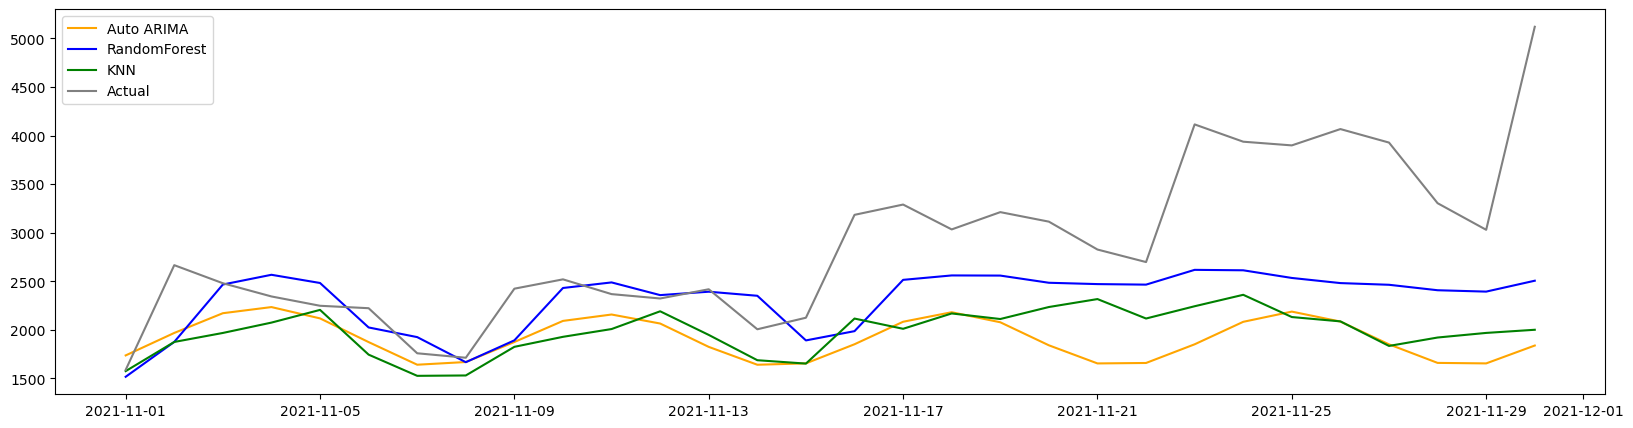

In [34]:
auto_arima_y = pd.DataFrame(auto_model.predict(n_periods=len(test), X=test.index),columns=['daily_cases'])
RandomForest_y = pd.DataFrame(rf_pred,index=test.index,columns=['daily_cases'])
knn_y = pd.DataFrame(knn_pred,index=test.index,columns=['daily_cases'])

plt.subplots(figsize=(20,5))
plt.plot(auto_arima_y, color = 'orange', label='Auto ARIMA')
plt.plot(RandomForest_y, color = 'blue', label='RandomForest')
plt.plot(knn_y, color = 'green', label='KNN')
plt.plot(test.tail(30), color ='grey', label='Actual')
plt.legend();

# 3. 5유형의 전력사용량 시계열 문제
### 데이터 설명
> - 데이터 설명 : 2050년 1년동안의 5유형(A,B,C,D,E)의 전력사용량을 나타낸다. 각유형의 전력사용량은 1분마다 갱신되며 그 값은 누적된다. 6시간이 지나면(00:00, 06:00, 12:00, 18:00시에) 전력사용량은 0으로 초기화 된다.
> - **problem2_usage.csv**: 6시간 간격의 총 전력사용량의 데이터이다. timestamp순서는 섞여있다. 6시간 간격의 특정 시간대(마지막시각 ‘05:59’,’11:59’,’17:59’,’23:59’)의 전력 총합을 나타낸다. 데이터의 총합을 구해서 비교할때 부동소수점 오류가 날수 있다. 파이썬의 경우 round(4)를 취하여 해결한다.
> - **problem2_usage_history.csv**: 1분간격의 A,B,C,D,E 유형의 소비 누적 전력을 나타낸다. 같은 6시간간격의 시간대의 데이터는 같은 “6hour_index”값을 가진다. 00:00, 06:00, 12:00, 18:00시에는 5유형의 전력은 초기화 된다. 데이터의 총합을 구해서 비교할때 부동소수점 오류가 날수 있다. 파이썬의 경우 round(4)를 취하여 해결한다.
> - **problem2_avg_tem.csv**: 2050년 1년동안 일자별 평균 온도를 나타낸다
- 출처: https://www.datamanim.com/dataset/ADPpb/00/15.html

In [ ]:
import pandas as pd
usage =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_usage.csv')
usage_history =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_usage_history.csv')
avg_temp = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/15/problem2_avg_tem.csv')

### 3-1. usage의 총사용량을 아래와 같은 모양으로 연월별 총합으로 계산하여 CSV 파일로 작성하시오
- 일자별 총사용량은 누적사용량이 갱신되기 직전의 최대값들의 합으로 계산한다
- [‘05:59’,’11:59’,’17:59’,’23:59’] 시간대의 A,B,C,D,E의 컬럼별 총합이 각 유형의 일일 사용량이다
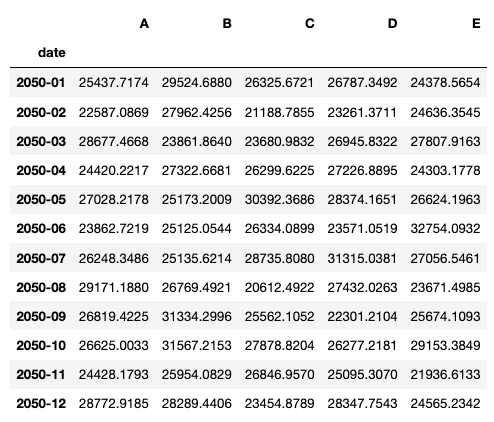

In [252]:
sum_time=['05:59','11:59','17:59','23:59']
usage_history['date'] = pd.date_range(start='2050-01-01', periods=365, freq='D').repeat(1440)
usage_history1 = usage_history.loc[usage_history["hh:mm"].isin(sum_time),['A','B','C','D','E','date']]

In [253]:
usage_m = usage_history1.groupby('date').agg({c:'sum' for c in usage_history1.columns[:-1]})
res1 = usage_m.resample('M').sum()
res1

,A,B,C,D,E
date,,,,,
2050-01-31,25437.7174,29524.6880,26325.6721,26787.3492,24378.5654
2050-02-28,22587.0869,27962.4256,21188.7855,23261.3711,24636.3545
2050-03-31,28677.4668,23861.8640,23680.9832,26945.8322,27807.9163
2050-04-30,24420.2217,27322.6681,26299.6225,27226.8895,24303.1778
2050-05-31,27028.2178,25173.2009,30392.3686,28374.1651,26624.1963
2050-06-30,23862.7219,25125.0544,26334.0899,23571.0519,32754.0932
2050-07-31,26248.3486,25135.6214,28735.8080,31315.0381,27056.5461
2050-08-31,29171.1880,26769.4921,20612.4922,27432.0263,23671.4985
2050-09-30,26819.4225,31334.2996,25562.1052,22301.2104,25674.1093


### 3-2. 가로축을 요일(일~월) 세로축을 평균 전력사용량으로 하는 그래프를 그려라. 각 유형별로 색을 다르게 표현하여 5개의 line plot을 그리며 범례를 표시하라

In [ ]:
res2 = usage_m.reset_index()
res2['weekday'] = res2['date'].dt.weekday.map(week_d)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
res2.groupby('weekday').agg({c:'mean' for c in ['A','B','C','D','E']} ).reindex(day_order, axis=0, level=0).plot(kind='line');

### 3-3. 요일별 각 유형의 평균 전력 사용량 간에 연관성이 있는지 검정하라

두변수간의 독립성을 확인하는 문제로, 카이제곱 독립성 검정으로 풀이한다

In [264]:
from scipy.stats import chi2_contingency
H0 ="유형별 평균 전력 사용량 간에 연관성이 없다"
H1 ="유형별 평균 전력 사용량 간에 연관성이 있다"

res3 = res2.melt(id_vars=['date','weekday'],var_name='type',value_name='usage')
observed = res3.pivot_table(index='weekday',columns='type',values='usage')
stats, p_val, dof, expected = chi2_contingency(observed)
print(f'카이제곱통계량: {stats:.3f}')
print(f'p_value: {p_val:.3f}')
# 유의수준 5%로 검증
if p_val<0.05:print(f'{H1}')
else:print(h0)    

카이제곱통계량: 83.760
p_value: 0.000
유형별 평균 전력 사용량 간에 연관성이 있다


### 3-4. 일자(매일)마다 각 유형의 전력사용량의 합을 데이터프레임으로 구하고 일자 데이터에서의 유형별 온도와의 상관계수를 각각 구하여라

In [265]:
usage_m['usage']=usage_m.loc[:,['A',	'B',	'C',	'D',	'E']].sum(axis=1)
usage = usage_m['usage'].reset_index()
avg_temp['date'] = pd.to_datetime(avg_temp['date'])
res4 = avg_temp.merge(usage,on='date')

In [266]:
res4[['temperature','usage']].corr()

,temperature,usage
temperature,1.000000,0.023307
usage,0.023307,1.000000


전력사용량과 온도와의 상관계수는 0.0233로 상관관계가 없다고 볼 수 있다